In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import random
import string

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
# df  # list all the runs in our run_dir

In [3]:
# task = "seq_relu_2nn"
#task = "sparse_linear_regression"
#task = "decision_tree"
# task = "relu_2nn_regression"
# task = "linear_regression"
# task = "seq_linear"
task = "seq_rec_linear"

run_id = "most_recent_squared_loss"
# run_id = "07cc4080-7c97-4ee7-a2eb-c2ea7c3257b8" # emma's slightly trained relu
# run_id = "squared_error_run" # december 5th relu, failed file lmao
# run_id = "d74dac35-5609-480f-ba44-091f72832849" # seq linear
# run_id = "first-successful"

# model name for plots, make sure to capitalize the first letter
model_size = "Toy"
# task name for plots
task_name = "sequential linear regression"

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = True

if recompute_metrics:
    # question: is this with the test set? -- i think so
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

100%|██████████| 1/1 [00:00<00:00, 13107.20it/s]


In [4]:
def save_current_figure(folder_path, file_name):
    if not os.path.exists("plots"):
        os.makedirs("plots")
    folder_path = "plots/" + folder_path
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    file_path = os.path.join(folder_path, file_name)
    plt.savefig(file_path)
    plt.close()

def generate_random_string(length=8):
    letters_and_digits = string.ascii_letters + string.digits
    random_string = ''.join(random.choice(letters_and_digits) for _ in range(length))
    return random_string

In [5]:
fig_output_dir = run_id + "_" + task + "_" + generate_random_string()

# Plot pre-computed metrics

seq_rec_linear most_recent_squared_loss


100%|██████████| 1/1 [00:00<00:00, 5890.88it/s]


metrics: {'standard': {'gpt2_embd=256_layer=12_head=8': {'mean': [1.0030803680419922, 0.49614793062210083, 0.13786305487155914, 0.058024417608976364, 0.032194964587688446, 0.025320256128907204, 0.020438944920897484, 0.01812935806810856, 0.016313711181282997, 0.014031356200575829, 0.012947676703333855], 'std': [0.09780904650688171, 0.2801053524017334, 0.15025398135185242, 0.08828375488519669, 0.04937491565942764, 0.03727743402123451, 0.03604753315448761, 0.03228464350104332, 0.028809798881411552, 0.017439501360058784, 0.016866687685251236], 'bootstrap_low': [0.9986035227775574, 0.48341313004493713, 0.13101109862327576, 0.05380065366625786, 0.029871175065636635, 0.02352941408753395, 0.01877106912434101, 0.016739413142204285, 0.015002290718257427, 0.013279763981699944, 0.01221989281475544], 'bootstrap_high': [1.0078704357147217, 0.5088323354721069, 0.14485402405261993, 0.06226145103573799, 0.034540459513664246, 0.027092311531305313, 0.0221244003623724, 0.019663196057081223, 0.017682256177

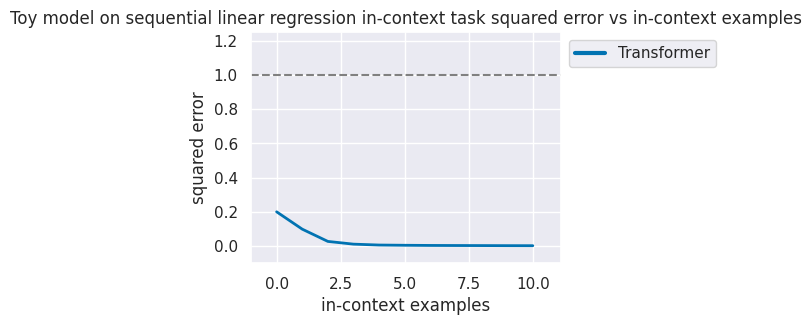

In [6]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
# todo: replace the task 
plt.title(model_size + " model on " + task_name + " in-context task squared error vs in-context examples")
plt.show()
# save_current_figure(fig_output_dir, "eval_on_all_models")

In [7]:
# plot any OOD metrics, out of distribution
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()
    if ("." in name):
        name = name.replace(".", "")
    # save_current_figure(fig_output_dir, "eval_on_all_models_ood_" + name)

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs.

In [8]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [9]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [10]:
def generate_random_ys(num_changes, num_total, b_dim, y_dim=0):
    """
    Selects num_changes random indices from the range 0 to num_total - 1.

    Args:
    - num_total (int): Total number of indices.
    - num_changes (int): Number of random indices to select.
    - b_dim (int): Dimension of a batch
    - y_dim (int): Dimension of y

    Returns:
    - torch.Tensor: Tensor containing the selected random indices. batch size x num changes 
    - torch.Tensor: Tensor containing the new random values at those indices
    """

    if num_changes > num_total:
        raise ValueError("Number of changes cannot be greater than the total number.")
    
    # Generate random indices
    # torch.randperm(len(pictures))[:10]

    random_indices = []

    # Generate random batches
    for _ in range(b_dim):
        # Generate a random permutation of 0 to num_total-1, taking only the first num_changes
        permutation = torch.range(0, num_changes - 1, 1).type(torch.int64)
        
        # Add the batch to the list
        random_indices.append(permutation)

    # Convert the list of batches to a PyTorch tensor
    random_indices = torch.stack(random_indices)

    if (y_dim == 0):
        indices_values = torch.rand((b_dim, num_changes))
    else: 
        indices_values = torch.rand((b_dim, num_changes, y_dim))

    return random_indices, indices_values

In [11]:
SEQ = "seq" in task

In [12]:
# can change this to be false
RANDOM_XS = False

In [13]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)

if not SEQ:
    ys = task.evaluate(xs)
    y_dim = 0
    print(ys.shape)
else: 
    xs, ys = task.generate_sequence(xs[:, 0, :], conf.model.n_positions)
    y_dim = ys.shape[2]
    print(ys.shape)

# randomness in (64 x 11) -- num_indices of 11 will be randomized
num_indices = [i for i in range(1, conf.model.n_positions)]
randomized_ys_array = []
randomized_xs_array = []

for num_changes in num_indices:
    if RANDOM_XS:
        randomized_xs = xs.clone()
        random_indices, x_indices_values = generate_random_ys(num_changes, randomized_xs.shape[1], randomized_xs.shape[0], xs.shape[2])

        for b in range(randomized_xs.shape[0]):
            randomized_xs[b][random_indices[b]] = x_indices_values[b]

        randomized_xs_array.append(randomized_xs)

    randomized_ys = ys.clone()
    random_indices, indices_values = generate_random_ys(num_changes, randomized_ys.shape[1], randomized_ys.shape[0], y_dim)
    if num_changes == 1: 
        print("random_indices", random_indices.shape)
        print("indices_values", indices_values.shape)

    for b in range(randomized_ys.shape[0]):
        if b == 0 and num_changes == 10:
            print("before random ys", randomized_ys[b])
        randomized_ys[b][random_indices[b]] = indices_values[b]

        if b == 0 and num_changes == 10:
            print(random_indices[b])
            print("after random ys", randomized_ys[b])

    randomized_ys_array.append(randomized_ys)

torch.Size([64, 11, 5])
random_indices torch.Size([64, 1])
indices_values torch.Size([64, 1, 5])
before random ys tensor([[ 0.2010,  0.6520, -0.4967,  0.2811, -0.4568],
        [-0.2431,  0.0870, -0.4128,  0.4674, -0.7378],
        [ 0.0467,  0.5116, -0.2851,  0.1471, -0.7957],
        [-0.0576, -0.0532, -0.6085,  0.6236, -0.4845],
        [-0.0868,  0.6376,  0.1149, -0.1987, -0.7302],
        [ 0.0693, -0.3930, -0.6401,  0.6564, -0.0117],
        [-0.1168,  0.6153,  0.4111, -0.4585, -0.4781],
        [ 0.1039, -0.5199, -0.5639,  0.5908,  0.2277],
        [-0.1148,  0.5775,  0.4916, -0.5281, -0.3643],
        [ 0.1104, -0.5494, -0.5317,  0.5627,  0.2943],
        [-0.1131,  0.5646,  0.5115, -0.5452, -0.3311]])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
after random ys tensor([[ 0.9060,  0.5124,  0.1478,  0.1387,  0.8841],
        [ 0.5147,  0.2420,  0.7502,  0.8600,  0.7181],
        [ 0.2256,  0.6275,  0.7407,  0.3342,  0.0516],
        [ 0.7356,  0.6161,  0.6696,  0.1903,  0.3067],
     

/home/emmaguo/in-context-learning/src/tasks.py:546: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2910.)
  eigenvalues, eigenvectors = torch.eig(w, eigenvectors=True)
/tmp/ipykernel_1649512/4143447168.py:27: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  permutation = torch.range(0, num_changes - 1, 1).type(torch.int64)


In [14]:
with torch.no_grad():
    pred = model(xs, ys)

pred = pred.squeeze()

print("pred", pred[0][1]) # getting the 0th sequence of the batch

# if not SEQ:
randomized_pred_array = []
for i in range(len(randomized_ys_array)):
    with torch.no_grad():
        if RANDOM_XS:
            randomized_pred = model(randomized_xs_array[i], randomized_ys_array[i])
        else:
            randomized_pred = model(xs, randomized_ys_array[i])
    randomized_pred = randomized_pred.squeeze()
    randomized_pred_array.append(randomized_pred)

# one random context
print(ys[0][1])
print(randomized_ys_array[9][0][1])
print(" ")
print(randomized_pred_array[9][0][1])

# with torch.no_grad():
#     randomized_pred = model(xs, randomized_ys_array[14])
#     print("random pred", randomized_pred[0])

#     # print("ys", ys[0][0])
#     # print("random ys", randomized_ys_array[14][0][0])
# randomized_pred = randomized_pred.squeeze() 


# NOTE: right now, if one piece of context is randomized, for instance, it is possible that it's not even included in the 
# context of the input for inputs of smaller size
    

pred tensor([-0.0358, -0.2924,  0.2112, -0.0130, -0.4219])


tensor([-0.2431,  0.0870, -0.4128,  0.4674, -0.7378])
tensor([0.5147, 0.2420, 0.7502, 0.8600, 0.7181])
 
tensor([ 0.1862, -0.2725,  0.3798, -0.0825,  0.0649])


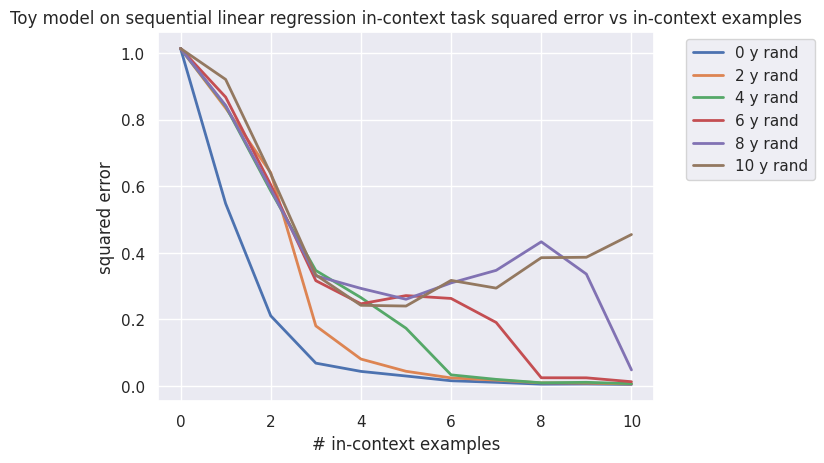

In [15]:
# it seems like the metric is just subtracting the predictions from the ys, but im confused because are the ys not like passed in as context?
metric = task.get_metric()
loss = metric(pred, ys).numpy()
randomized_loss = metric(randomized_pred, ys).numpy()
# randomized_loss_w_random = metric(randomized_pred, randomized_ys).numpy()

# get eval accuracy
# print(ys[0][0])
# print(pred[0][0])
# print(torch.eq(ys, pred))

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
    "seq_relu_2nn": 0,
    "seq_linear": 1,
    "seq_rec_linear": 0,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="0 y rand")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
# save_current_figure(fig_output_dir, "eval_on_transformer")

# if (not SEQ):

for n in range(1, len(randomized_pred_array), 2):
    randomized_loss = metric(randomized_pred_array[n], ys).numpy()
    
    plt.plot(randomized_loss.mean(axis=0), lw=2, label=str(n + 1) + " y rand")
    # plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
    # plt.xlabel("# in-context examples")
    # plt.ylabel("squared error")
    # plt.legend()
    # plt.title(model_size + " model on " + task_name + " in-context task squared error vs in-context examples (with randomness)")
    # plt.show()
    # save_current_figure(fig_output_dir, "eval_on_transformer_" + str(num_random) + "_randomized_context")

plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(model_size + " model on " + task_name + " in-context task squared error vs in-context examples")
plt.show()

# plt.plot(randomized_loss_w_random.mean(axis=0), lw=2, label="Transformer with randomized context")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
# plt.xlabel("# in-context examples")
# plt.ylabel("squared error")
# plt.legend()
# plt.show()